In [1]:
#Importando pandas,numpy e matplotlib para manipulacao dos dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#carregando o conjunto de dados dos padroes de digitacao
dados = pd.read_csv('C:/Users/Eustacio Cuatane/Desktop/Laboratorios/DatasetTcc.csv')

In [ ]:
# carregando o conjunto de dados dos utilizadores
usuarios = pd.read_csv('C:/Users/Eustacio Cuatane/Desktop/Laboratorios/user.csv')

# ANÁLISE EXPLORATÓRIA 

In [7]:
# verificando a quantidade de linhas e colunas no dataset
dados.shape

(11743, 39)

In [ ]:
# verificando as primeiras 5 linhas no dataset
dados.head()

In [ ]:
# verificando as 5 ultimas linhas do dataset
dados.tail()

In [ ]:
#listando colunas
dados.columns

In [ ]:
# verificando se existem valores nulos no dataset
dados.isnull().sum()

In [ ]:
#informacoes do dataset
dados.info()

In [ ]:
#dados estatisticos
dados.describe()

In [ ]:
#quantidade de dados por utilizador
dados['Nome'].value_counts()

# PRÉ-PROCESSAMENTO

In [9]:
# funcao para buscar utilizadores abaixo de 250 amostras de digitacao e limpar do dataFrame
def remover_classes_poucos_dados(df, coluna_classe, limiar=250):
    
    contagem_classes = df[coluna_classe].value_counts()
    classes_remover = contagem_classes[contagem_classes < limiar].index
    df_filtrado = df[~df[coluna_classe].isin(classes_remover)]

    return df_filtrado

dados_filtrados = remover_classes_poucos_dados(dados, 'Nome', limiar=250)
dados=dados_filtrados

In [10]:
#codificando as classes
from sklearn import preprocessing as pr
encoder=pr.LabelEncoder()
dados['Nome']=encoder.fit_transform(dados['Nome'])
classes = encoder.classes_

In [17]:
# obtendo o numero de classes 
num_classes = len(encoder.classes_)

In [ ]:
# grafico de distribuicao dos utilizadores por faixa etaria e genero
total_faixa_etaria = usuarios['Faixa'].value_counts()

df_plot = usuarios.groupby(['Faixa', 'Sexo']).size().unstack(fill_value=0)


fig, ax = plt.subplots()
ax.bar(df_plot.index, df_plot['Masculino'], label='Masculino')
ax.bar(df_plot.index, df_plot['Femenino'], bottom=df_plot['Masculino'], label='Feminino')

plt.yticks(np.arange(0, 32, 2))

plt.xlabel('Faixa Etária')
plt.ylabel('Quantidade de Pessoas')
plt.title('Distribuição das pessoas por faixa etária e genero')

plt.legend()

plt.show()

In [ ]:
# grafico de distribuicao dos utilizadores pela quantidade de amostras
contagem_por_utilizador = dados['Nome'].value_counts()
utilizadores_ordenados = contagem_por_utilizador.sort_values()
utilizadores_ordenados.plot.bar()
plt.xlabel('ID do Utilizador')
plt.ylabel('Quantidade de amostras')
plt.title('Distribuição dos Utilizadores pela quantidade de amostras')
plt.show()

In [7]:
# separando as classes das caracteristicas
from numpy.matrixlib.defmatrix import matrix
matriz = dados.values
x = matriz[:,1:39]
y = matriz[:,0]

In [8]:
#dividindo os dados de treinamento e testes
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(x,y, test_size=0.2 , random_state=0) 


In [ ]:
X_train.shape


In [ ]:
X_test.shape

# **IMPLEMENTAÇÃO DOS ALGORITMOS DE APRENDIZADO DE MÁQUINA**

## Optimização de hiperparâmetros : Random Forest Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Grid de hiperparametros para o modelo
n_estimators = [250,300]
max_depth = [20,25]
criterion = ["gini", "entropy"]
max_features = ["sqrt", "log2"]
min_samples_split = [2,3]
min_samples_leaf = [2,3]
bootstrap = [True, False]


grid_parametros = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'criterion': criterion,
    'max_features': max_features,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
}

# Criacao do modelo RandomForestClassifier
randomforest = RandomForestClassifier(random_state=42)

# Modelo com a grid de hiperparametros
grid_search_RFC = GridSearchCV(
    estimator=randomforest,
    param_grid=grid_parametros,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=2,
    return_train_score=True,
    
)

# Ajustando o modelo aos dados de treinamento
grid_search_RFC.fit(X_train, y_train)


print(f"Melhor pontuacao : {grid_search_RFC.best_score_}")
print(f"Melhores hiperparâmetros: {grid_search_RFC.best_params_}")


In [ ]:
#Testando o modelo Random forest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay,precision_score,f1_score, recall_score,ConfusionMatrixDisplay 

y_test_pred_rfc = grid_search_RFC.predict(X_test) 

# Desempenho no conjunto de teste

print("*********Desempenho no conjunto de Teste***********")
acuracia_score_test=accuracy_score(y_test,y_test_pred_rfc)
precision_score_test=precision_score(y_test,y_test_pred_rfc, average="weighted")
f1_score_test=f1_score(y_test,y_test_pred_rfc,average='weighted')
recall_score_test=recall_score(y_test,y_test_pred_rfc,average='weighted')

print(f'acuracia no conjunto de teste:{acuracia_score_test:.4f}')
print(f'precisao no conjunto de teste:{precision_score_test:.4f}')
print(f'F1 score no conjunto de teste:{f1_score_test:.4f}')
print(f'revocacao no conjunto de teste:{recall_score_test:.4f}')

print("************Matriz de confusao RFC***************")
matrix_confusao_rfc =confusion_matrix(y_test,y_test_pred_rfc)
disp = ConfusionMatrixDisplay(matrix_confusao_rfc)
plt.figure(figsize=(8, 6))
disp.plot()
plt.show()

#reportagem de classificacao para o conjunto de teste
print("**************Reportagem de classificacao****************")
reportagem_classificacao_rfc = classification_report(y_test,y_test_pred_rfc)
print(reportagem_classificacao_rfc)

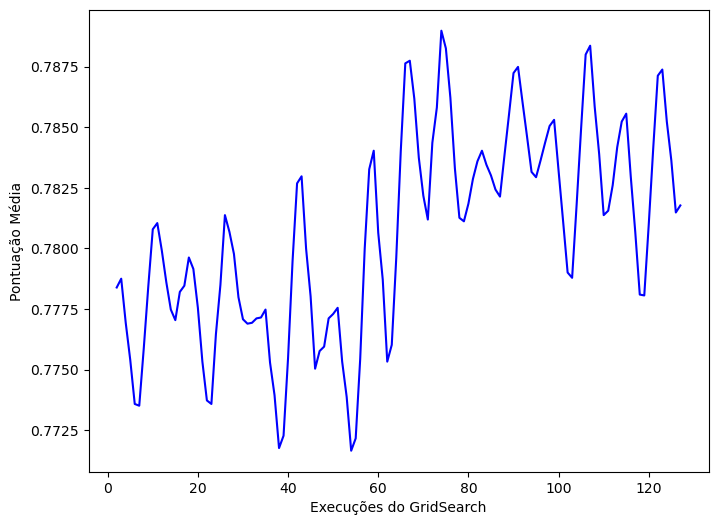

In [12]:
# plotar as pontuacoes medias 
resultados_grid_rfc = grid_search_RFC.cv_results_

mean_test_scores_rfc = resultados_grid_rfc['mean_test_score']
num_execucoes_rfc = len(resultados_grid_rfc['params'])

smoothed_scores = np.convolve(mean_test_scores_rfc, np.ones(3)/3, mode='valid')

plt.figure(figsize=(8, 6))
plt.plot(range(2, num_execucoes_rfc), smoothed_scores, linestyle='-', color='b')

plt.xlabel('Execuções do GridSearch')
plt.ylabel('Pontuação Média')

plt.show()


In [19]:
# Calculando o total de acertos e erros do modelo Random forest
acertos = np.sum(np.diag(matrix_confusao_rfc))
erros = np.sum(matrix_confusao_rfc) - acertos
print("Número de Acertos:", acertos)
print("Número de Erros:", erros)

Número de Acertos: 1854
Número de Erros: 435


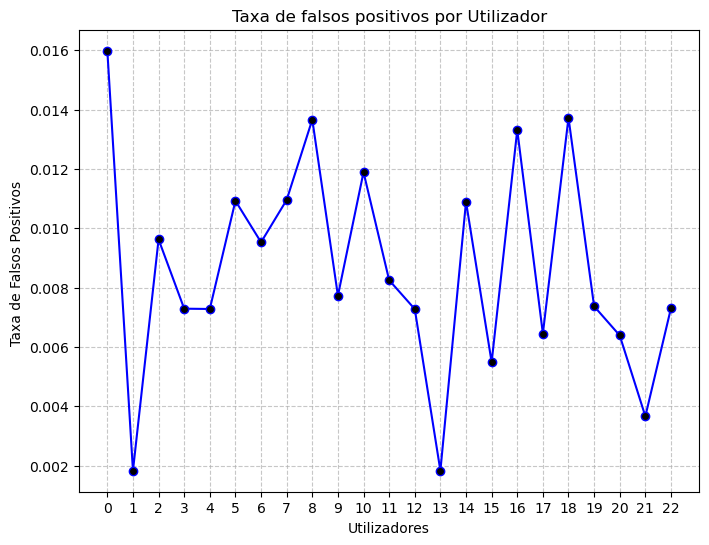

In [20]:
# Plotar as taxas de falsos positivos por classe 
fpr_classes = []
tpr_classes = []

for classe in range(num_classes):
    TP = matrix_confusao_rfc[classe, classe]
    FP = sum(matrix_confusao_rfc[:, classe]) - TP
    FN = sum(matrix_confusao_rfc[classe, :]) - TP
    TN = np.sum(matrix_confusao_rfc) - TP - FP - FN

    FPR_classe = FP / (FP + TN) if (FP + TN) > 0 else 0
    TPR_classe = TP / (TP + FN) if (TP + FN) > 0 else 0

    fpr_classes.append(FPR_classe)
    tpr_classes.append(TPR_classe)


plt.figure(figsize=(8, 6))
plt.plot(range(num_classes), fpr_classes, marker='o', linestyle='-', color='b',markerfacecolor='black')
plt.title('Taxa de falsos positivos por Utilizador')
plt.xlabel('Utilizadores')
plt.ylabel('Taxa de Falsos Positivos ')
plt.xticks(range(num_classes))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
import pandas as pd
resultados_grid_rfc = resultados_grid_RFC['resultados_cv']
mean_test_scores = resultados_grid_rfc['mean_test_score']
 
num_execucoes_total = len(mean_test_scores)
numero_de_folds = 5

num_execucoes_por_fold = num_execucoes_total // numero_de_folds

# Calcular as pontuaccoes maximas alcancadas em cada fold
pontuacoes_maximas = []
desvios_padrao = []
for i in range(numero_de_folds):
    indices_execucoes_fold = np.arange(num_execucoes_por_fold * i, num_execucoes_por_fold * (i + 1))
    pontuacao_maxima_fold = np.max(mean_test_scores[indices_execucoes_fold])
    desvio_padrao_fold = np.std(mean_test_scores[indices_execucoes_fold])
    pontuacoes_maximas.append(pontuacao_maxima_fold)
    desvios_padrao.append(desvio_padrao_fold)

# Criar o DataFrame com os resultados
df_resultados = pd.DataFrame({
    'Fold': np.arange(1, numero_de_folds+1),
    'Pontuação Máxima': pontuacoes_maximas,
    'Desvio Padrão': desvios_padrao
})

# Mostrar a tabela
print(df_resultados)


# Optimização de hiperparâmetros : eXtreme Gradient Boosting

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid_XGboost = {
    'n_estimators': [100,50, 300],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
    
}

xgboost = xgb.XGBClassifier(objective='multi:softmax',num_class=num_classes,random_state=42)

grid_search_XGboost = GridSearchCV(
    estimator=xgboost,
    param_grid=param_grid_XGboost,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=2,
    return_train_score=True
)

# Ajustando o modelo aos dados de treinamento
grid_search_XGboost.fit(X_train, y_train)

print("Melhores hiperparâmetros:", grid_search_XGboost.best_params_)
print("Melhor pontuação:", grid_search_XGboost.best_score_)

*********Desempenho no conjunto de Teste***********
acuracia no conjunto de teste:0.8633
precisao no conjunto de teste:0.8647
F1 score no conjunto de teste:0.8634
revocacao no conjunto de teste:0.8633
***************Matriz de confusao******************


<Figure size 1000x800 with 0 Axes>

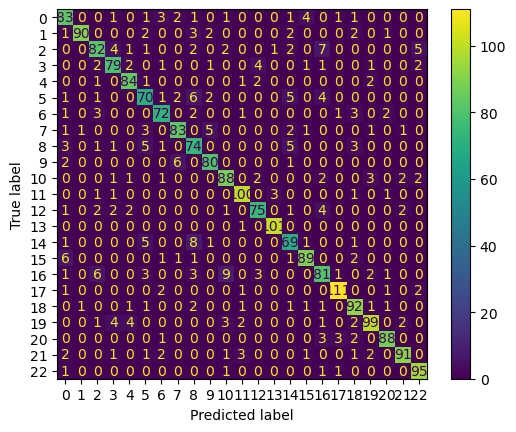

*************reportagem de classificacao ********
              precision    recall  f1-score   support

         0.0       0.79      0.84      0.81        99
         1.0       0.98      0.87      0.92       103
         2.0       0.82      0.77      0.79       107
         3.0       0.84      0.84      0.84        94
         4.0       0.88      0.92      0.90        91
         5.0       0.75      0.76      0.76        92
         6.0       0.85      0.85      0.85        85
         7.0       0.88      0.85      0.86        98
         8.0       0.73      0.80      0.76        93
         9.0       0.88      0.90      0.89        89
        10.0       0.83      0.86      0.85       102
        11.0       0.91      0.93      0.92       107
        12.0       0.87      0.83      0.85        90
        13.0       0.96      0.99      0.98       102
        14.0       0.77      0.80      0.78        86
        15.0       0.91      0.88      0.89       101
        16.0       0.77      0.

In [294]:
#Testando o modelo XGboost
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay,precision_score,f1_score, recall_score,ConfusionMatrixDisplay 
y_test_pred_xgboost =grid_search_XGboost.predict(X_test)

# Desempenho no conjunto de teste

print("*********Desempenho no conjunto de Teste***********")
acuracia_score_test=accuracy_score(y_test,y_test_pred_xgboost)
precision_score_test=precision_score(y_test,y_test_pred_xgboost, average="weighted")
f1_score_test=f1_score(y_test,y_test_pred_xgboost,average='weighted')
recall_score_test=recall_score(y_test,y_test_pred_xgboost,average='weighted')

print(f'acuracia no conjunto de teste:{acuracia_score_test:.4f}')
print(f'precisao no conjunto de teste:{precision_score_test:.4f}')
print(f'F1 score no conjunto de teste:{f1_score_test:.4f}')
print(f'revocacao no conjunto de teste:{recall_score_test:.4f}')

# Matriz de confusao

print("***************Matriz de confusao******************")
Matriz_confusao_XGboost =confusion_matrix(y_test,y_test_pred_xgboost)
disp=ConfusionMatrixDisplay(Matriz_confusao_XGboost)
plt.figure(figsize=(10, 8))
disp.plot()
plt.show()

reportagem_classificacao_Xgboost=classification_report(y_temp,y_test_pred_xgboost)
print("*************reportagem de classificacao ********")
print(reportagem_classificacao_Xgboost)


In [295]:
# Calculando o total de acertos e erros do modelo XGboost
acertos = np.sum(np.diag(Matriz_confusao_XGboost))
erros = np.sum(Matriz_confusao_XGboost) - acertos
print("Número de Acertos:", acertos)
print("Número de Erros:", erros)

Número de Acertos: 1976
Número de Erros: 313


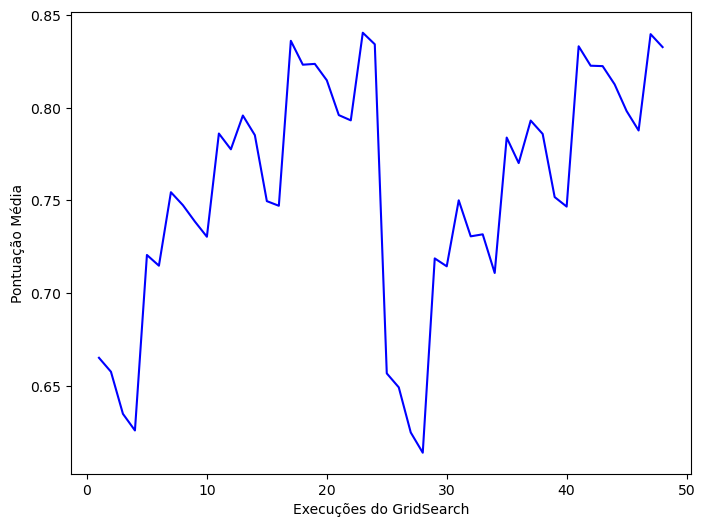

In [291]:
#plotar as pontuacoes medias
resultados_grid_xgboost = grid_search_XGboost.cv_results_

mean_test_scores_xgboost = resultados_grid_xgboost['mean_test_score']
num_execucoes_xgboost = len(resultados_grid_xgboost['params'])

plt.figure(figsize=(8, 6))
plt.plot(range(1, num_execucoes_xgboost + 1), mean_test_scores_xgboost, linestyle='-', color='b')

plt.xlabel('Execuções do GridSearch')
plt.ylabel('Pontuação Média')

plt.show()


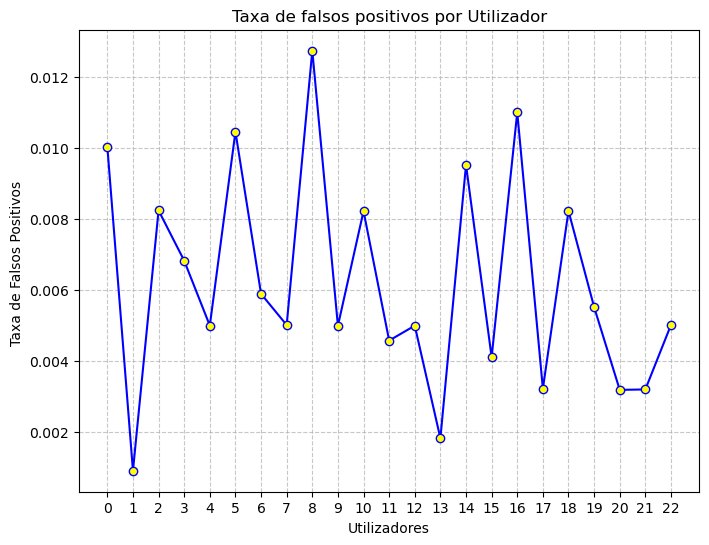

In [289]:
# Plotar as taxas de falsos positivos por classe 
fpr_classes = []
tpr_classes = []

for classe in range(num_classes):
    TP = Matriz_confusao_XGboost[classe, classe]
    FP = sum(Matriz_confusao_XGboost[:, classe]) - TP
    FN = sum(Matriz_confusao_XGboost[classe, :]) - TP
    TN = np.sum(Matriz_confusao_XGboost) - TP - FP - FN

    FPR_classe = FP / (FP + TN) if (FP + TN) > 0 else 0
    TPR_classe = TP / (TP + FN) if (TP + FN) > 0 else 0

    fpr_classes.append(FPR_classe)
    tpr_classes.append(TPR_classe)


plt.figure(figsize=(8, 6))
plt.plot(range(num_classes), fpr_classes, marker='o', linestyle='-', color='b',markerfacecolor='yellow')
plt.title('Taxa de falsos positivos por Utilizador')
plt.xlabel('Utilizadores')
plt.ylabel('Taxa de Falsos Positivos ')
plt.xticks(range(num_classes))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [73]:
resultados_grid_xgboost = grid_search_XGboost.cv_results_
mean_test_scores = resultados_grid_xgboost['mean_test_score']

num_execucoes_total = len(mean_test_scores)

# numero de folds
numero_de_folds = 5

num_execucoes_por_fold = num_execucoes_total // numero_de_folds

# Calcular as pontuacoes maximas alcancadas em cada fold
pontuacoes_maximas = []
desvios_padrao = []
for i in range(numero_de_folds):
    indices_execucoes_fold = np.arange(num_execucoes_por_fold * i, num_execucoes_por_fold * (i + 1))
    pontuacao_maxima_fold = np.max(mean_test_scores[indices_execucoes_fold])
    desvio_padrao_fold = np.std(mean_test_scores[indices_execucoes_fold])
    pontuacoes_maximas.append(pontuacao_maxima_fold)
    desvios_padrao.append(desvio_padrao_fold)

# Criar o DataFrame com os resultados
df_resultados = pd.DataFrame({
    'Fold': np.arange(1, numero_de_folds+1),
    'Pontuação Máxima': pontuacoes_maximas,
    'Desvio Padrão': desvios_padrao
})

# Mostrar a tabela
print(df_resultados)


   Fold  Pontuação Máxima  Desvio Padrão
0     1          0.754424       0.047056
1     2          0.836137       0.032990
2     3          0.840507       0.083483
3     4          0.783919       0.045856
4     5          0.833187       0.029014


# Optimização de hiperparâmetros : Light Gradient Boosting Machine

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=num_classes)
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 300],
    'max_depth': [5, 10,20],
    'num_leaves': [20,31,40],
    'feature_fraction':[0.9,0.8]
}
grid_search_LigthGBM = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=5,scoring='accuracy')
grid_search_LigthGBM.fit(X_train, y_train)

print("Melhores hiperparâmetros:", grid_search_LigthGBM.best_params_)
print("Melhor pontuação:", grid_search_LigthGBM.best_score_)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
*******Desempenho no conjunto de Teste**********
acuracia no conjunto de teste:0.8606
precisao no conjunto de teste:0.8616
F1 score no conjunto de teste: 0.8603
recall no conjunto de teste: 0.8606
*******Matriz de confusao conjunto de teste**********


<Figure size 1000x800 with 0 Axes>

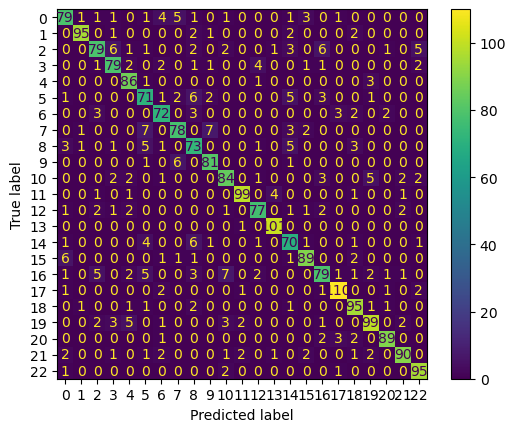

*******Reportagem de classificacao para o conjunto de teste**********
              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81        99
         1.0       0.96      0.92      0.94       103
         2.0       0.84      0.74      0.79       107
         3.0       0.83      0.84      0.84        94
         4.0       0.84      0.95      0.89        91
         5.0       0.72      0.77      0.75        92
         6.0       0.82      0.85      0.83        85
         7.0       0.85      0.80      0.82        98
         8.0       0.73      0.78      0.76        93
         9.0       0.87      0.91      0.89        89
        10.0       0.83      0.82      0.83       102
        11.0       0.94      0.93      0.93       107
        12.0       0.89      0.86      0.87        90
        13.0       0.94      0.99      0.97       102
        14.0       0.75      0.81      0.78        86
        15.0       0.90      0.88      0.89       101
        16.

In [268]:
# Testes do modelo LigthGBM
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,precision_score,f1_score, recall_score,ConfusionMatrixDisplay 

y_test_pred = grid_search_LigthGBM.predict(X_test) 

print("*******Desempenho no conjunto de Teste**********")
acuracy_test=accuracy_score(y_test,y_test_pred)
precision_test =precision_score(y_test,y_test_pred,average='weighted')
f1_test=f1_score(y_test,y_test_pred,average='weighted')
recall_test=recall_score(y_test,y_test_pred,average='weighted')

print(f'acuracia no conjunto de teste:{acuracy_test:.4f}')
print(f'precisao no conjunto de teste:{precision_test:.4f}')
print(f'F1 score no conjunto de teste: {f1_test:.4f}')
print(f'recall no conjunto de teste: {recall_test:.4f}')


# Matriz de confusao conjunto de teste
print("*******Matriz de confusao conjunto de teste**********")
matriz_confusaoLightGBM =confusion_matrix(y_test,y_test_pred)
disp = ConfusionMatrixDisplay(matriz_confusaoLightGBM)
plt.figure(figsize=(10, 8))
disp.plot()
plt.show()

#Reportagem de classificacao para o conjunto de teste
print("*******Reportagem de classificacao para o conjunto de teste**********")
reportagem_classificacaoLightGBM = classification_report(y_test,y_test_pred)
print(reportagem_classificacaoLightGBM)


In [207]:
# Calculando o total de acertos e erros do modelo LightGBM
acertos = np.sum(np.diag(matriz_confusaoLightGBM))
erros = np.sum(matriz_confusaoLightGBM) - acertos
print("Número de Acertos:", acertos)
print("Número de Erros:", erros)


Número de Acertos: 1970
Número de Erros: 319


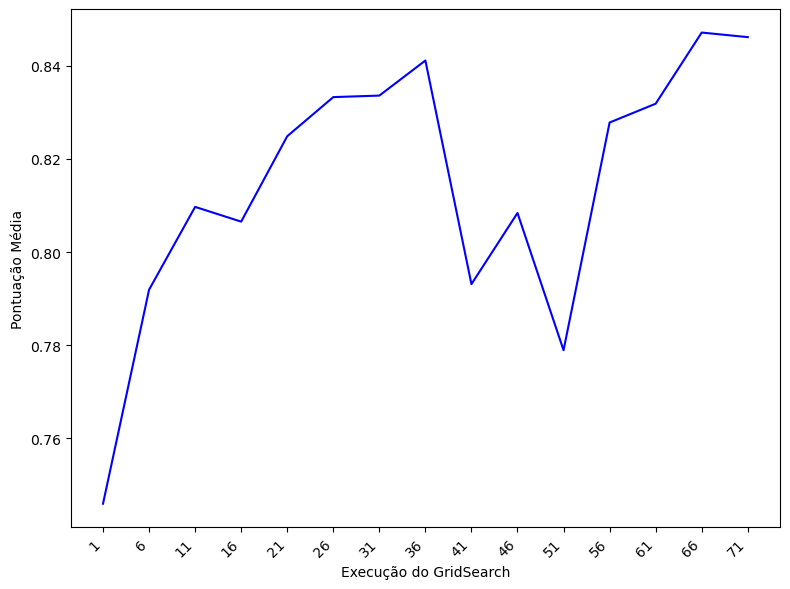

In [292]:
# Plotar as pontuacoes medias 
resultados_grid = grid_search_LigthGBM.cv_results_
mean_test_scores = resultados_grid['mean_test_score']

indices = np.arange(len(resultados_grid['params']))
indices_selecionados = np.arange(1, 73, 5)


plt.figure(figsize=(8, 6))
plt.plot(indices_selecionados, mean_test_scores[indices_selecionados - 1], linestyle='-', color='b')

plt.xlabel('Execução do GridSearch')
plt.ylabel('Pontuação Média')
plt.xticks(range(1, 74, 5), rotation=45, ha='right')

plt.tight_layout()
plt.show()


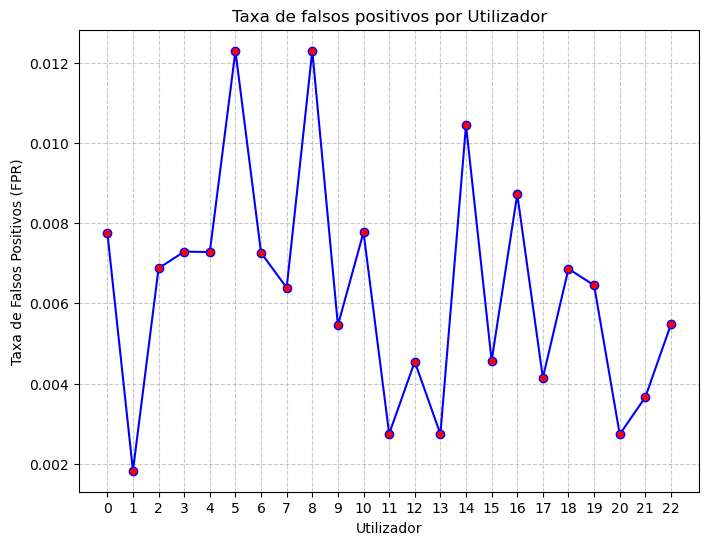

In [253]:
# taxas de falsos positivos por classe
fpr_classes = []
tpr_classes = []

for classe in range(num_classes):
    TP = matriz_confusaoLightGBM[classe, classe]
    FP = sum(matriz_confusaoLightGBM[:, classe]) - TP
    FN = sum(matriz_confusaoLightGBM[classe, :]) - TP
    TN = np.sum(matriz_confusaoLightGBM) - TP - FP - FN

    FPR_classe = FP / (FP + TN) if (FP + TN) > 0 else 0
    TPR_classe = TP / (TP + FN) if (TP + FN) > 0 else 0

    fpr_classes.append(FPR_classe)
    tpr_classes.append(TPR_classe)


plt.figure(figsize=(8, 6))
plt.plot(range(num_classes), fpr_classes, marker='o', linestyle='-', color='b',markerfacecolor='red')
plt.title('Taxa de falsos positivos por Utilizador')
plt.xlabel('Utilizador')
plt.ylabel('Taxa de Falsos Positivos (FPR)')
plt.xticks(range(num_classes))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [75]:
mean_test_scores = resultados_grid['mean_test_score']

num_execucoes_total = len(mean_test_scores)

numero_de_folds = modelo_carregado.n_splits_
num_execucoes_por_fold = num_execucoes_total // numero_de_folds

# Calcular as pontuacoes maximas alcancadas em cada fold
pontuacoes_maximas = []
desvios_padrao = []
for i in range(numero_de_folds):
    indices_execucoes_fold = np.arange(num_execucoes_por_fold * i, num_execucoes_por_fold * (i + 1))
    pontuacao_maxima_fold = np.max(mean_test_scores[indices_execucoes_fold])
    desvio_padrao_fold = np.std(mean_test_scores[indices_execucoes_fold])
    pontuacoes_maximas.append(pontuacao_maxima_fold)
    desvios_padrao.append(desvio_padrao_fold)

# Criar o DataFrame com os resultados
df_resultados = pd.DataFrame({
    'Fold': np.arange(1, numero_de_folds+1),
    'Pontuação Máxima': pontuacoes_maximas,
    'Desvio Padrão': desvios_padrao
})

# Mostrar a tabela
print(df_resultados)


   Fold  Pontuação Máxima  Desvio Padrão
0     1          0.809700       0.022309
1     2          0.846515       0.018698
2     3          0.847389       0.037680
3     4          0.827944       0.020766
4     5          0.848808       0.006163
